# Lib loading


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
def normalize(dataset):
  zero_x, zero_y, zero_z = dataset.accel_x[0], dataset.accel_y[0], dataset.accel_z[0]
  # dataset.accel_x -= zero_x
  # dataset.accel_y -= zero_y
  # dataset.accel_z -= zero_z

  # zero_x, zero_y, zero_z = dataset.gyro_x[0], dataset.gyro_y[0], dataset.gyro_z[0]
  # dataset.gyro_x -= zero_x
  # dataset.gyro_y -= zero_y
  # dataset.gyro_z -= zero_z

  return dataset

In [3]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_circle/SM2_B1A104.csv"
dataset = pd.read_csv(url)

In [4]:
dataset.head()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,-0.021240,0.014526,0.997559,1.937866,-2.197266,3.326416
1,-0.021484,0.014404,0.997559,1.739502,-1.770020,2.532959
2,-0.020386,0.015625,0.997559,1.571655,-1.419067,1.922607
3,-0.020386,0.015991,0.998413,1.083374,-0.854492,1.403809
4,-0.020996,0.016235,0.999756,0.610352,-0.289917,0.991821


# Integration function


Here I'm going to approximate an integral by rectangles beneath the curve


In [5]:
def integrate(data, times):
    accumulated_speed = 0.0

    last_time = times[0]
    speeds = []

    for i in range(1, len(times)):
        time = times[i]

        delta_t = time - last_time
        delta_v = data[i] * delta_t

        accumulated_speed += delta_v

        speeds.append(accumulated_speed)
        last_time = time
    return speeds

# Gyro data explored

In [6]:
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)

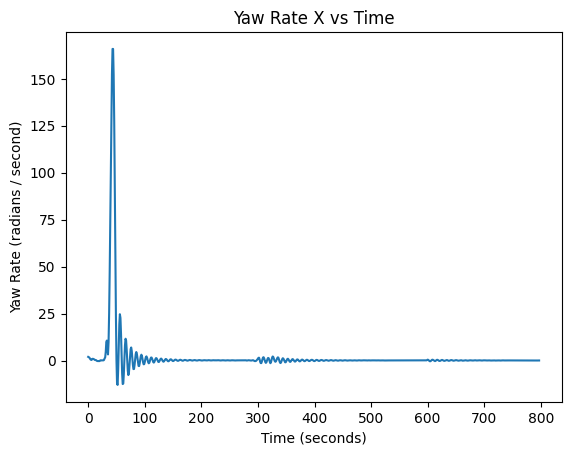

In [7]:
plt.title("Yaw Rate X vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Yaw Rate (radians / second)")
plt.plot(TIMESTAMPS, YAW_RATES[0])
plt.show()

In [8]:
def get_angle(YAW_RATES, TIMESTAMPS):
  thetas_x = integrate(YAW_RATES[0], TIMESTAMPS)
  thetas_y = integrate(YAW_RATES[1], TIMESTAMPS)
  thetas_z = integrate(YAW_RATES[2], TIMESTAMPS)

  ANGLES = [thetas_x, thetas_y, thetas_z]
  return ANGLES

In [9]:
ANGLES = get_angle(YAW_RATES, TIMESTAMPS)

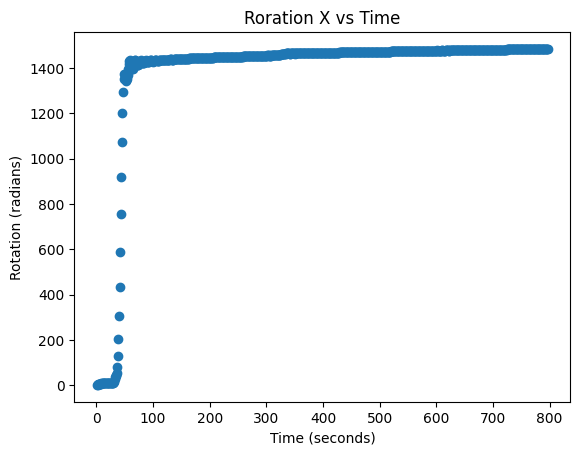

In [10]:
plt.title("Roration X vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Rotation (radians)")
plt.scatter(TIMESTAMPS[1:], ANGLES[0])
plt.show()

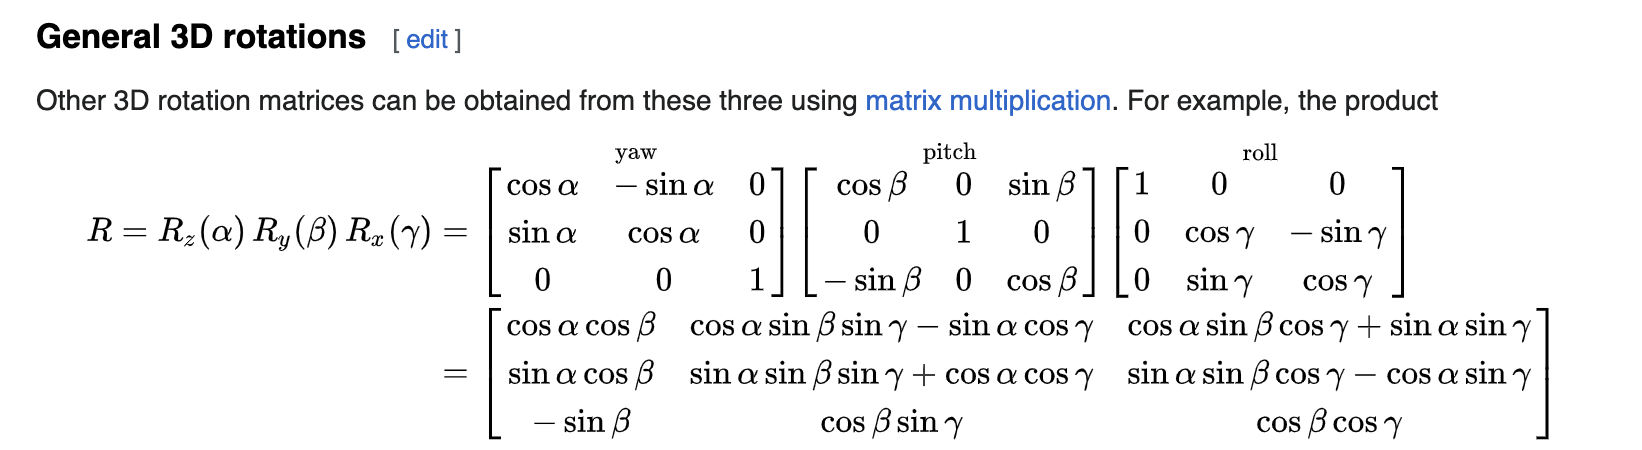

In [11]:
#calculate rotation matrix for each measurement
#calculation is done according to the image from wikipedia above

def get_rotation_matr(ANGLES):
  MATRICES = []

  for i in range(len(ANGLES[0])):
    alpha = (ANGLES[0][i]) #x
    beta = (ANGLES[1][i]) #y
    gamma = (ANGLES[2][i]) #z

    c_a, s_a = np.cos(alpha), np.sin(alpha)
    # R_x = np.array([[1, 0, 0], [0, c_a, -s_a], [0, s_a, c_a]])

    c_b, s_b = np.cos(beta), np.sin(beta)
    # R_y = np.array([[c_b, 0, s_b], [0, 1, 0], [-s_b, 0, c_b]])

    c_g, s_g = np.cos(gamma), np.sin(gamma)
    # R_z = np.array([[c_g, -s_g, 0], [s_g, c_g, 0], [0, 0, 1]])

    R = [[c_b*c_g, s_a*s_b*c_g - c_a*s_g, c_a*s_b*c_g + s_a*s_g],
         [c_b*s_g, s_a*s_b*s_g + c_a*c_g, c_a*s_b*s_g - s_a*c_g],
         [-s_b, s_a*c_b, c_a*c_b]]

    #MATRICES.append((R_z.dot(R_y)).dot(R_x))
    MATRICES.append(R)

  return MATRICES

# Gyro and Accelerometer data combined

In [12]:
#calculate new accelerations by multiplying rotation matrix by acceleration vector

def callibrate(ACCELERATIONS, YAW_RATES, TIMESTAMPS):
  ANGLES = get_angle(YAW_RATES, TIMESTAMPS)
  MATRICES = get_rotation_matr(ANGLES)

  new_acc = [[], [], []]

  for i in range(len(MATRICES)):
    matrix = np.array(MATRICES[i])
    vector = np.array([ACCELERATIONS[0][i], ACCELERATIONS[1][i], ACCELERATIONS[2][i]])
    res = (matrix.dot(vector)).tolist()
    new_acc[0].append(res[0])
    new_acc[1].append(res[1])
    new_acc[2].append(res[2] - 1) #subtracting g(ravity) from accelerometer measurements

  return new_acc

In [13]:
#get position for the sensor by double integrating accelerations from the previous step

def get_position(ACCELERATIONS, TIMESTAMPS):
  # Now we use the function we just defined
  integrated_speeds_x = integrate(ACCELERATIONS[0], TIMESTAMPS)
  integrated_displ_x = integrate(integrated_speeds_x,
                                                  TIMESTAMPS[1:])

  integrated_speeds_y = integrate(ACCELERATIONS[1], TIMESTAMPS)
  integrated_displ_y = integrate(integrated_speeds_y,
                                                  TIMESTAMPS[1:])

  integrated_speeds_z = integrate(ACCELERATIONS[2], TIMESTAMPS)
  integrated_displ_z = integrate(integrated_speeds_z,
                                                  TIMESTAMPS[1:])

  position = [integrated_displ_x, integrated_displ_y, integrated_displ_z]
  return position


In [14]:
def get_plot(x, y, z):
  ax = plt.axes(projection='3d')
  ax.plot3D(x, y, z)

In [15]:
def plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS):
  ACCELERATIONS_NEW = callibrate(ACCELERATIONS, YAW_RATES, TIMESTAMPS)
  position = get_position(ACCELERATIONS_NEW, TIMESTAMPS[1:])
  get_plot(position[0], position[1], position[2])

# Anna's dataset, flat squiggle

In [16]:
# url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_flat_2/SM2_B1A104.csv"
# dataset = pd.read_csv(url)
# dataset = normalize(dataset)

# TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
# YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
# ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

# plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS)

# Anna's dataset, flat rectangle

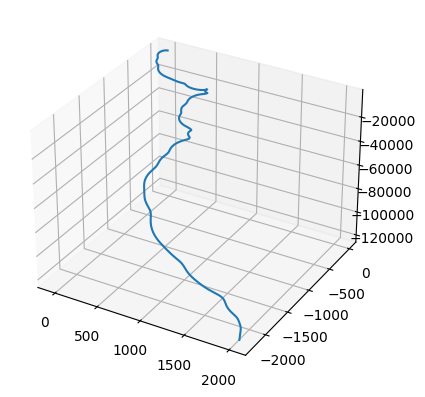

In [31]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_flat_1/SM2_B0A105.csv"
dataset = pd.read_csv(url)
# dataset = normalize(dataset)

TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS)

In [18]:
dataset.head()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,-0.027466,0.077515,0.996948,-1.052856,0.106812,5.798340
1,-0.028687,0.082275,0.996216,-1.129150,-0.305176,2.395630
2,-0.032349,0.091187,0.996338,-1.068115,-0.488281,-0.885010
3,-0.030762,0.086914,0.997070,-0.915527,-0.564575,-2.532959
4,-0.030518,0.094971,0.997314,-0.579834,-0.518799,-4.623413


# Anna's dataset, circles

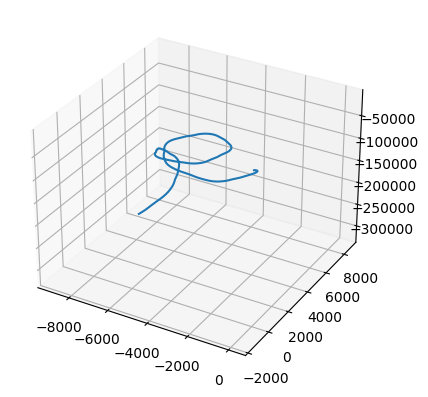

In [29]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_circle/SM2_B1A105.csv"
dataset = pd.read_csv(url)
dataset = normalize(dataset)

TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS)